<a href="https://colab.research.google.com/github/nomadicsenseis/annoted-transformer/blob/main/The_Annoted_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reproducción del annoted transformer de Harvard NLP

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

# Contexto
El objetivo de reducir el cómputo secuencial también es parte de la base de la GPU Neuronal Extendida, de ByteNet y de ConvS2S, todos los cuales utilizan redes neuronales convolucionales como bloque de construcción básico, calculando representaciones ocultas en paralelo para todas las posiciones de entrada y salida. En estos modelos, el número de operaciones requeridas para relacionar señales de dos posiciones arbitrarias de entrada o salida crece en la distancia entre posiciones, linealmente para ConvS2S y logarítmicamente para ByteNet. Esto hace que sea más difícil aprender las dependencias entre posiciones distantes. En el Transformer, esto se reduce a un número constante de operaciones, aunque a costa de una resolución efectiva reducida debido al promedio de las posiciones ponderadas por atención, un efecto que contrarrestamos con la atención multi-head.

El mecanismo de self-attention, a veces llamada intra-atención, es un mecanismo de atención que relaciona diferentes tókenes de una sola secuencia para calcular una representación contextual de cada token en la secuencia. La autoatención se ha utilizado con éxito en una variedad de tareas que incluyen comprensión de lectura, resumen abstracto, vinculación textual y aprendizaje de representaciones de oraciones independientes de la tarea. Las redes de memoria de extremo a extremo se basan en un mecanismo de atención recurrente en lugar de una recurrencia secuencial alineada, y se ha demostrado que funcionan bien en tareas simples de modelado de lenguaje y respuesta a preguntas.

Sin embargo, hasta donde sabemos, el Transformer es el primer modelo de transducción que se basa completamente en la autoatención para calcular representaciones de su entrada y salida sin usar RNN secuencialmente alineadas o redes convolucionales.

#Arquitectura del modelo
La mayoría de los modelos neuronales más competitivos en la tarea de traducción de secuencias  tienen una estructura de codificador-decodificador. Aquí, el codificador mapea una secuencia de entrada de representaciones de tókenes no contextuales $(x_1,...,x_n)$ en una secuencia de representaciones continuas contextuales de dichos tókenes **z**$=(z_1,...,z_n) $. Dado **z**, el decodificador genera una secuencia de tókenes de salida $(y_1,...,y_m)$ elemento a elemento. En cada paso el modelo es auto-regresivo, consumiendo los tókenes generados previamente como entrada adicional al generar el siguiente.

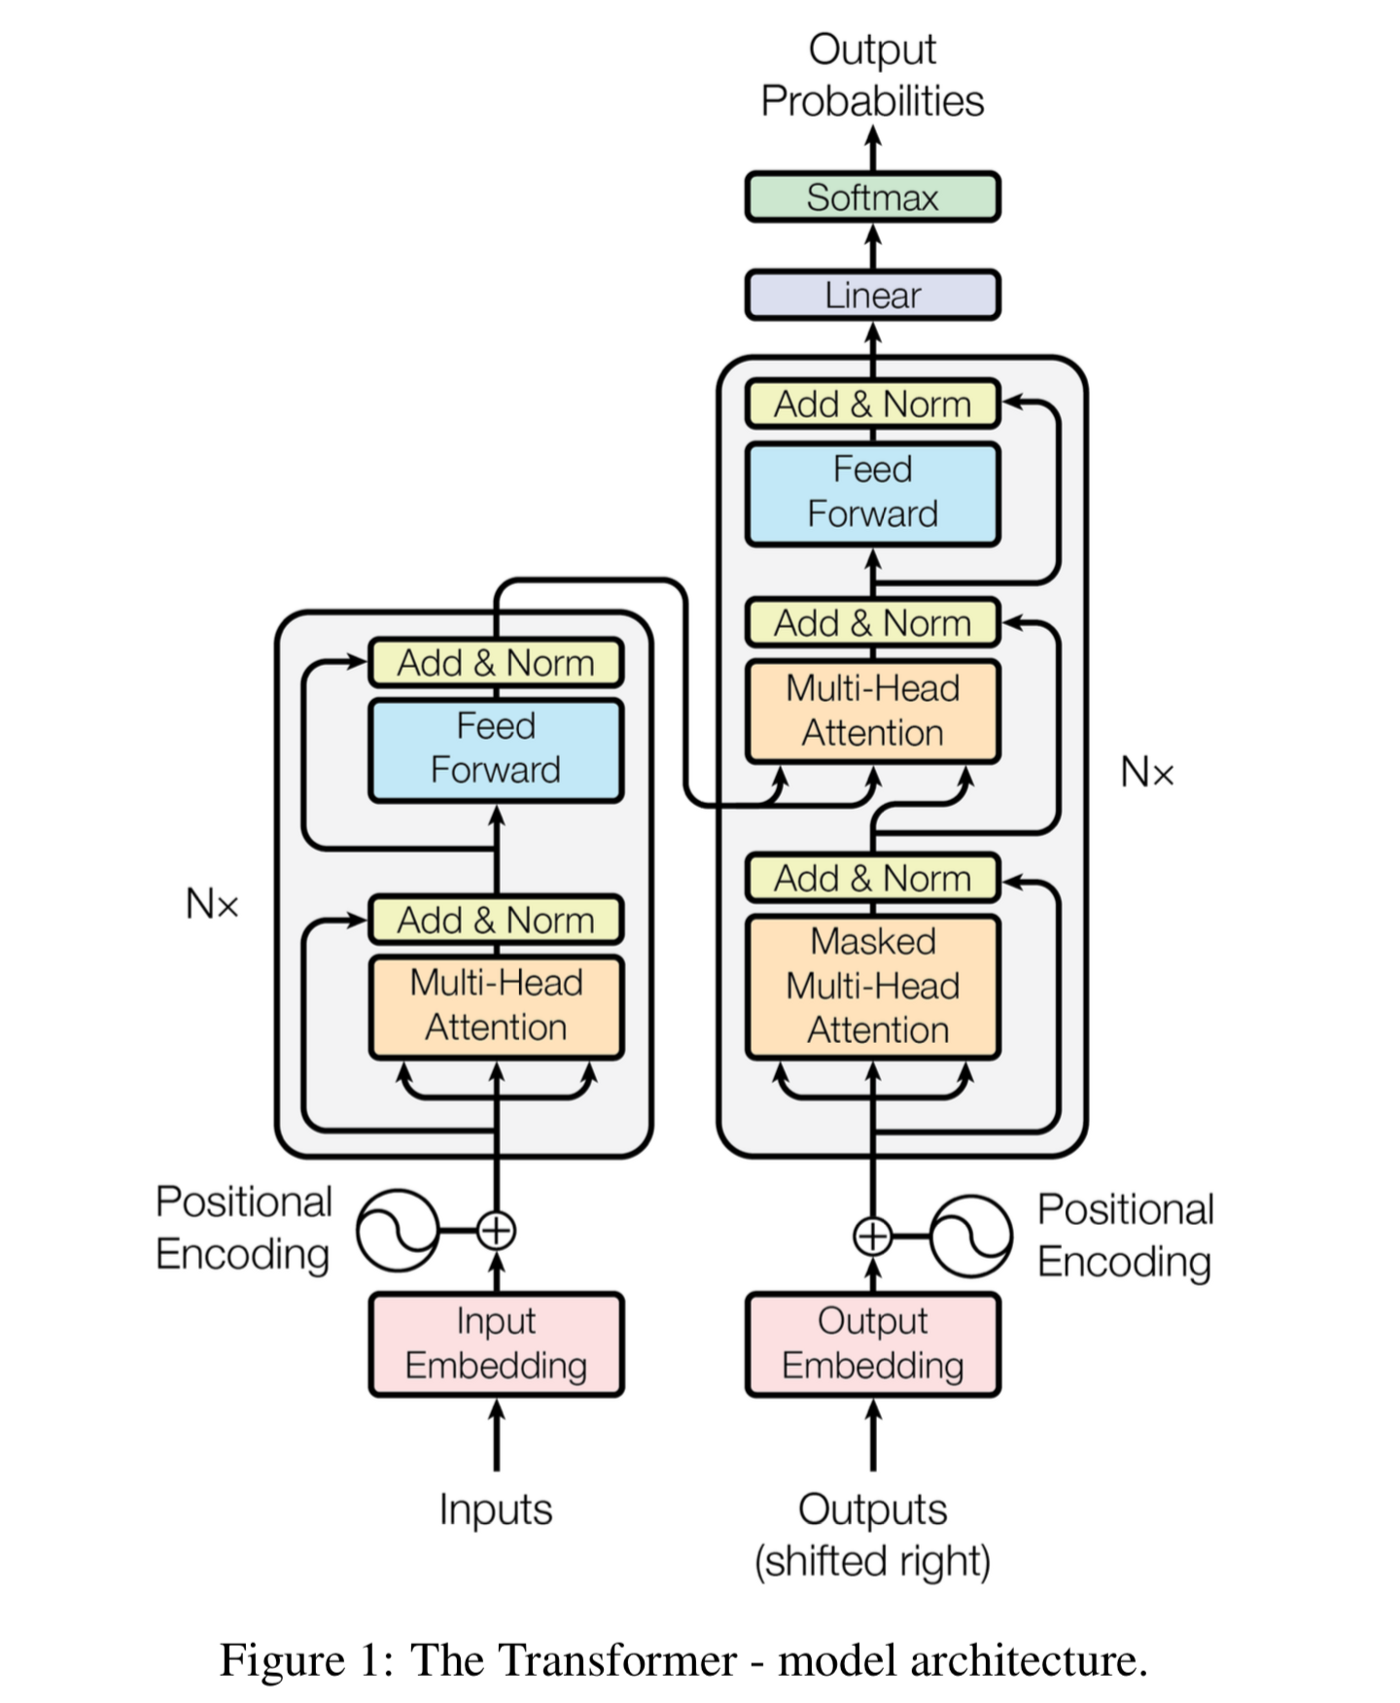

In [ ]:
from IPython.display import Image
Image(filename='/content/transformer.png')

Aunque esta imagen es la forma habitual de presentar la arquitectura transformer, loc ierto es que no es demasiado exhaustiva. Aquí dejo una versión en pseudocódigo, sacada de un apper de OpenAi y presente en mi trabajo Attention is not all you need.

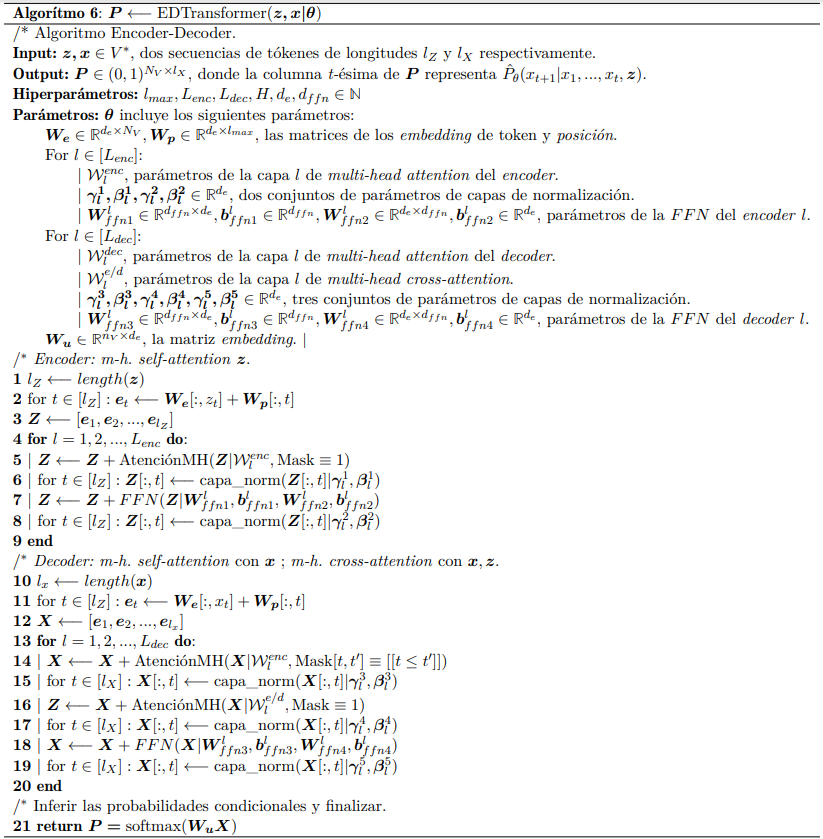

In [ ]:
from IPython.display import Image
Image(filename='/content/EDTRansformer.png')

Quizás sería interesante programar este algoritmo sin utilizar una filosofía de OOP, pero 

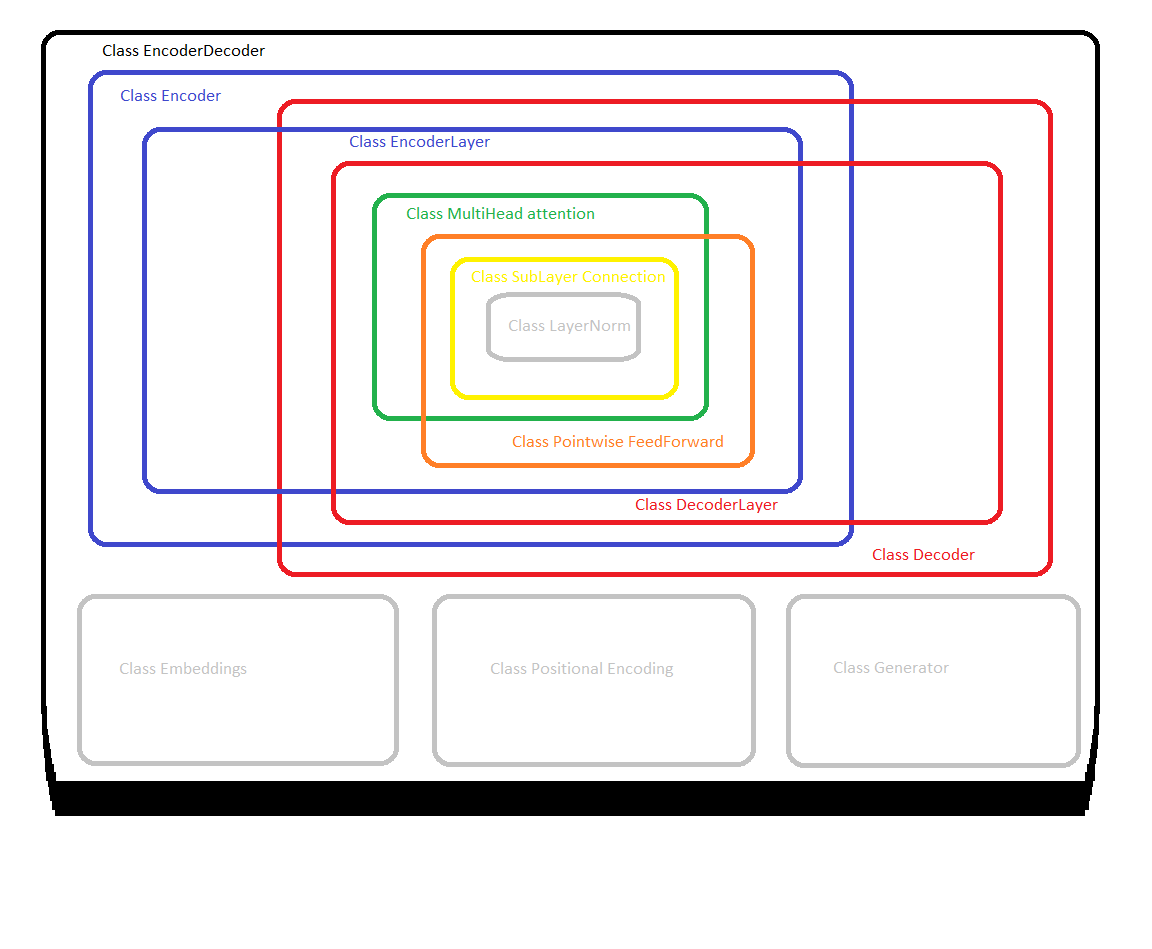

In [ ]:
from IPython.display import Image
Image(filename='/content/Estrucura de clases transformer.png')

In [ ]:
class EncoderDecoder(nn.Module):
  """
  Arquitectura estándar Codificador-Decodificador. 
  """

  def __init__(self, encoder, decoder, ori_embed, obj_embed, generator):
    super(EncoderDecoder,self).__init__()
    self.encoder=encoder
    self.decoder=decoder
    self.ori_embed=ori_embed
    self.obj_embed=obj_embed
    self.generator=generator

  def forward(self,ori,obj,ori_mask,obj_mask):
    "Ingerir y procesar la seqcuencia de origen y la objetivo"
    return self.decode(self.encode(ori,ori_mask),ori_mask,obj,obj_mask)

  def encode(self, ori, ori_mask):
    return self.encoder(self, ori, ori_mask)

  def decode(self,memory, ori_mask, obj, obj_mask):
    return self.decoder(self.obj_embed(obj), memory, ori_mask, obj_mask)

In [ ]:
class Generator(nn.Module):
  """
  se define el paso Feed Forward
  """
  def __init__(self, d_model, vocab):
    super(Generator, self).__init__()
    self.proj=nn.Linear(d_model,vocab)

  def forward(self,x):
    return F.log_softmax(self.proj(x),dim=-1)

Superponiendo estos dos módulos se consiguen las distintas arquiteccturas de Transformer, siendo la de Encoder-Decoder la más general (y la original del papes de Attention is all you need). 

# Módulos de Encoder y Decoder
##Encoder
El encoder se compone de 6 capas idénticas.
N=6

In [ ]:
def clones(module,N):
  """
  Produce N capas idénticas.
  """
  return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

Se aplica una conexión residual alrededor de las 2 sub-capas, seguida de una capa de normalización.

In [ ]:
class CapaNorm(nn.Module):
  """
  Se construye un modulo capa de normalización.
  """
  def __init__(self, caracteristicas,eps=1e-6):
    super(CapaNorm, self).__init__()
    self.a_2=nn.Parameter(torch.ones(caracteristicas))
    self.b_2=nn.Parameter(torch.zeros(caracteristicas))
    self.eps=eps

  def forward(self,x):
    mean=x.mean(-1,keepdim=True)
    std=x.std(-1,keepdim=True)
    return self.a_2*(x-mean)/(std+self.eps)+self.b_2

In [ ]:
class ConexionSubCapa(nn.Module):
  """
  Una conexión residual seguida de una capa de normalización. 
  """

  def __init__(self, tamaño, dropout):
    super(ConexionSubCapa,self).__init__()
    norm=CapaNorm(tamaño)
    self.dropout=nn.Dropout(dropout)

  def forward(self, x, subcapa):
    "Aplica conexion residual a cualquier sub capa con el mismo tamaño."
    return x + self.dropout(subcapa(self.norm(x)))


In [ ]:
class Encoder(nn.Module):
  """
  El núcleo del encoder es un stack de N capas
  """
  def __init__(self,capa,N):
    super(Encoder, self).__init__()
    self.capas = clones(capa,N)
    self.norm= CapaNorm(capa.size)

  def forward(self,x,mask):
    """
    Pasa el input (y máscara) a traves de cada capa en respuesta.
    """
    for capa in self.capas:
      x=capa(x,mask)
    return self.norm(x)

In [ ]:
class CapaEncoder(nn.Module):
  def __init__(self,tamaño,self_attn,PFF,dropout):
    super(CapaEncoder,self).__init__()
    self.self_attn=self_attn
    self.PFF=PFF
    self.subcapa=clones(ConexionSubCapa(tamaño,dropout),2)
    self.tamaño=tamaño

  def forward(self, x,mask):
    x=self.subcapa[0](x,lambda x: self.self_attn(x,x,x,mask))
    return self.subcapa[1](x, self.PFF)
    


In [ ]:
class Decoder(nn.Module):
  """
  Decoder genérico con N capas y máscara.
  """
  def __init__(self, capa,N):
    super(Decoder,self).__init__()
    self.capas=clones(capa,N)
    self.norm=CapaNorm(capa.size)

  def forward(self,x, memoria, ori_mask, obj_mask):
    for capa in self.capas:
      x=capa(x,memoria,ori_mask,obj_mask)
    return self.norm(x)

In [ ]:
class CapaDecoder(nn.Module):

  def __init__(self, tamaño, self_attn, cross_attn, PFF, dropout):
    super(CapaDecoder,self).__init__()
    self.tamaño=tamaño
    self.self_attn=self_attn
    self.cross_attn=cross_attn
    self.PFF=PFF
    self.subcapa=clones(ConexionSubCapa(tamaño,dropout),3)

  def forward(self,x,memoria,ori_mask,obj_mask):
    m=memoria
    x=self.subcapa[0](x, lambda x: self.self_atten(x,x,x,obj_mask))
    x=self.subcapa[1](x, lambda x: self.ori_mask(x,m,m, ori_mask))
    return self.subcapa[2](x,self.PFF)


In [ ]:
def MaskUnidireccional(tamaño):
  attn_shape=(1,tamaño,tamaño)
  mask=np.triu(np.ones(attn_shape),k=1).astype('uint8')
  return torch.from_numpy(mask)==0

In [ ]:
def attention(query, key, value, mask=None, dropout=None):
  d_k=query.size(-1)
  scores=torch.matmul(query,key.transpose(-2,-1)) / math.sqrt(d_k)
  if mask is not None:
    scores=scores.masked_fill(mask==0,-1e9)
    p_attn=F.softmax(scores,dim=-1)
  if dropout is not None:
    p_attn=dropout(p_attn)
  return torch.matmul(p_attn,value),p_attn


In [ ]:
class MultiHeadedattention(nn.Module):
  def __init__(self,h,d_model,dropout=0.1):
    super(MultiHeadedattention,self).__init__()
    assert d_model % h ==0 
    self.d_k=d_model//h
    self.h=h
    self.linears=clones(nn.Linear(d_model,d_model),4)
    self.attn=None
    self.dropout=nn.Dropout(p=dropout)

  def forward(self, query, key, value, mask=None):
    if mask is not None:
      mask=mask.unsqueeze(1)
    nbatches=query.size(0)
  # 1) hacer todas las proyecciones lineales en lotes desde d_model => h x d_k
    query,key,value= [l(x).view(nbatches,-1,self.h, self.d_k).transpose(1,2) for l,x in zip(self.linears,(query,key,value))]
  # 2) Aplicar el mecanismod e atención en todos los vectores proyectdos por lotes.
    x, self.attn=attention(query,key,value,mask=mask,dropout=self.dropout)
  # 3) Concatenar utilizando un view y aplicar la capa lineal final.
    x=x.transpose(1,2).contiguous().view(nbatches,-1,self.h*self.d_k)

    return self.linears[-1](x)
    

In [ ]:
class PositionwiseFeedForward(nn.Module):
  def __init__(self,d_model,d_ff,dropout=0.1):
    super(PositionwiseFeedForward,self).__init__()
    self.w_1=nn.Linear(d_model,d_ff)
    self.w_2=nn.Linear(d_ff,d_model)
    self.dropout=nn.Dropout(dropout)

  def forward(self,x):
    return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [ ]:
class Embeddings(nn.Module):

  def __init__(self, d_model, vocab):
    super(Embeddings,self).__init__()
    self.lut=nn.Embedding(vocab,d_model)
    self.d_model=d_model

  def forward(self,x):
    return self.lut(x)*math.sqrt(self.d_model)

In [ ]:
class PositionalEncoding(nn.Module):

  def __init__(self,d_model,dropout,max_len=5000):
    super(PositionalEncoding,self).__init__()
    self.dropout=nn.Dropout(p=dropout)

    #Calcula los positional encodings una vez en el espacion log
    pe=torch.zeros(max_len, d_model)
    position=torch.arrange(0,max_len).unsqueeze(1)
    div_term=torch.exp(torch.arange(0,d_model,2)*
                       -(math.log(10000.0)/d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
  def forward(self, x):
    x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
    return self.dropout(x)
    